In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler

In [24]:
try:
    df = pd.read_csv('online_shoppers_intention.csv')
    print("Dataset berhasil dimuat.")
    print(f"Jumlah baris: {df.shape[0]}, Jumlah kolom: {df.shape[1]}\n")
except FileNotFoundError:
    print("Error: File 'online_shoppers_intention.csv' tidak ditemukan.")
    print("Pastikan Anda sudah mengunduh dataset dan meletakkannya di folder yang sama.")
    exit()

Dataset berhasil dimuat.
Jumlah baris: 12330, Jumlah kolom: 18



In [25]:
categorical_cols = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType']
target_col = 'Revenue'

In [26]:
df_processed = df.copy()

In [27]:
import requests

# URL dataset dari UCI Machine Learning Repository
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv'

# Nama file lokal
file_name = 'online_shoppers_intention.csv'

try:
    response = requests.get(url)
    response.raise_for_status()  # Memunculkan HTTPError untuk status kode error

    with open(file_name, 'wb') as f:
        f.write(response.content)
    print(f'File "{file_name}" berhasil diunduh.')
except requests.exceptions.RequestException as e:
    print(f'Error saat mengunduh file: {e}')
    print('Pastikan Anda memiliki koneksi internet dan URL dataset benar.')
    print('Alternatif: unggah file "online_shoppers_intention.csv" secara manual ke lingkungan Colab Anda.')


File "online_shoppers_intention.csv" berhasil diunduh.


In [28]:
import pandas as pd
try:
    df = pd.read_csv('online_shoppers_intention.csv')
    print("Dataset berhasil dimuat.")
    print(f"Jumlah baris: {df.shape[0]}, Jumlah kolom: {df.shape[1]}\n")
except FileNotFoundError:
    print("Error: File 'online_shoppers_intention.csv' tidak ditemukan.")
    print("Pastikan Anda sudah mengunduh dataset atau mengunggahnya ke folder yang sama.")


Dataset berhasil dimuat.
Jumlah baris: 12330, Jumlah kolom: 18



In [29]:
encoder = OrdinalEncoder()
df_processed[categorical_cols] = encoder.fit_transform(df_processed[categorical_cols])

In [30]:
df_processed['Weekend'] = df_processed['Weekend'].astype(int)
df_processed[target_col] = df_processed[target_col].astype(int)


In [31]:
X = df_processed.drop(target_col, axis=1) # Semua kolom KECUALI 'Revenue'
y = df_processed[target_col]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Data Latih: {X_train.shape[0]} baris")
print(f"Data Uji: {X_test.shape[0]} baris\n")


Data Latih: 9864 baris
Data Uji: 2466 baris



In [33]:
print("Memulai pelatihan model Random Forest (Baseline)...")
start_time_baseline = time.time()
model_rf_baseline = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model_rf_baseline.fit(X_train, y_train)
end_time_baseline = time.time()
print(f"Pelatihan model baseline selesai. (Durasi: {end_time_baseline - start_time_baseline:.2f} detik)\n")

Memulai pelatihan model Random Forest (Baseline)...
Pelatihan model baseline selesai. (Durasi: 2.21 detik)



In [34]:
print("--- Hasil Evaluasi Model Baseline (Sebelum Tuning) ---")
y_pred_baseline = model_rf_baseline.predict(X_test)
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)

print(f"Akurasi: {accuracy_baseline:.4f}")
print("\nLaporan Klasifikasi Baseline:")
print(classification_report(y_test, y_pred_baseline, target_names=['Tidak Beli (0)', 'Beli (1)']))
print("\nConfusion Matrix Baseline:")
print(confusion_matrix(y_test, y_pred_baseline))
print("-" * 60 + "\n")

--- Hasil Evaluasi Model Baseline (Sebelum Tuning) ---
Akurasi: 0.9006

Laporan Klasifikasi Baseline:
                precision    recall  f1-score   support

Tidak Beli (0)       0.92      0.96      0.94      2084
      Beli (1)       0.74      0.56      0.64       382

      accuracy                           0.90      2466
     macro avg       0.83      0.76      0.79      2466
  weighted avg       0.89      0.90      0.89      2466


Confusion Matrix Baseline:
[[2007   77]
 [ 168  214]]
------------------------------------------------------------



In [35]:
print("Memulai Optimasi Hyperparameter (Grid Search)...")
print("Ini mungkin akan memakan waktu beberapa menit...")
start_time_grid = time.time()

Memulai Optimasi Hyperparameter (Grid Search)...
Ini mungkin akan memakan waktu beberapa menit...


In [36]:
param_grid = {
    'n_estimators': [100, 200],         # Jumlah pohon
    'max_depth': [10, 20, None],       # Kedalaman maksimum
    'min_samples_split': [2, 5],       # Batas minimum sampel untuk split
    'criterion': ['gini', 'entropy']   # Fungsi evaluasi
    }

In [37]:
rf_grid = RandomForestClassifier(random_state=42, n_jobs=-1)

# Inisialisasi GridSearch
# cv=5 (cross-validation 5-fold) adalah praktik umum
# scoring='accuracy' karena kita ingin memaksimalkan akurasi
grid_search = GridSearchCV(estimator=rf_grid,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           verbose=1,
                           n_jobs=-1)

# Latih GridSearch untuk menemukan parameter terbaik
grid_search.fit(X_train, y_train)

end_time_grid = time.time()
print(f"Optimasi Grid Search selesai. (Durasi: {end_time_grid - start_time_grid:.2f} detik)\n")

# --- Tampilkan Hasil Grid Search ---
print("--- Hasil Optimasi Grid Search ---")
print(f"Parameter Terbaik Ditemukan: {grid_search.best_params_}")
print(f"Akurasi Terbaik (Cross-Validation): {grid_search.best_score_:.4f}\n")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Optimasi Grid Search selesai. (Durasi: 232.33 detik)

--- Hasil Optimasi Grid Search ---
Parameter Terbaik Ditemukan: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Akurasi Terbaik (Cross-Validation): 0.9061



In [38]:
# Ini adalah "Arsitektur Deep Learning" yang harus kamu jelasin ke dosen
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)), # Input & Hidden 1
    Dropout(0.2),                                                  # Biar gak gampang 'lupa'
    Dense(32, activation='relu'),                                  # Hidden 2
    Dense(1, activation='sigmoid')                                 # Output (Beli/Nggak)
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [40]:
print("--- Hasil Evaluasi Model Optimal (Setelah Tuning) ---")

# Gunakan model terbaik yang sudah dilatih (best_estimator_) untuk prediksi
best_model = grid_search.best_estimator_
y_pred_optimal = best_model.predict(X_test)
accuracy_optimal = accuracy_score(y_test, y_pred_optimal)

print(f"Akurasi pada Data Uji: {accuracy_optimal:.4f}")
print("\nLaporan Klasifikasi Model Optimal:")
print(classification_report(y_test, y_pred_optimal, target_names=['Tidak Beli (0)', 'Beli (1)']))
print("\nConfusion Matrix Model Optimal:")
print(confusion_matrix(y_test, y_pred_optimal))
print("-" * 60 + "\n")

# ===================================================================
# TAHAP 6: ANALISIS HASIL (Perbandingan)
# ===================================================================
print("--- Perbandingan Performa Model ---")
print(f"Akurasi Model Baseline (Sebelum Tuning): {accuracy_baseline:.4f}")
print(f"Akurasi Model Optimal (Setelah Tuning):   {accuracy_optimal:.4f}")
print(f"Peningkatan Akurasi: {accuracy_optimal - accuracy_baseline:.4f}")

--- Hasil Evaluasi Model Optimal (Setelah Tuning) ---
Akurasi pada Data Uji: 0.9035

Laporan Klasifikasi Model Optimal:
                precision    recall  f1-score   support

Tidak Beli (0)       0.92      0.97      0.94      2084
      Beli (1)       0.75      0.57      0.64       382

      accuracy                           0.90      2466
     macro avg       0.84      0.77      0.79      2466
  weighted avg       0.90      0.90      0.90      2466


Confusion Matrix Model Optimal:
[[2012   72]
 [ 166  216]]
------------------------------------------------------------

--- Perbandingan Performa Model ---
Akurasi Model Baseline (Sebelum Tuning): 0.9006
Akurasi Model Optimal (Setelah Tuning):   0.9035
Peningkatan Akurasi: 0.0028


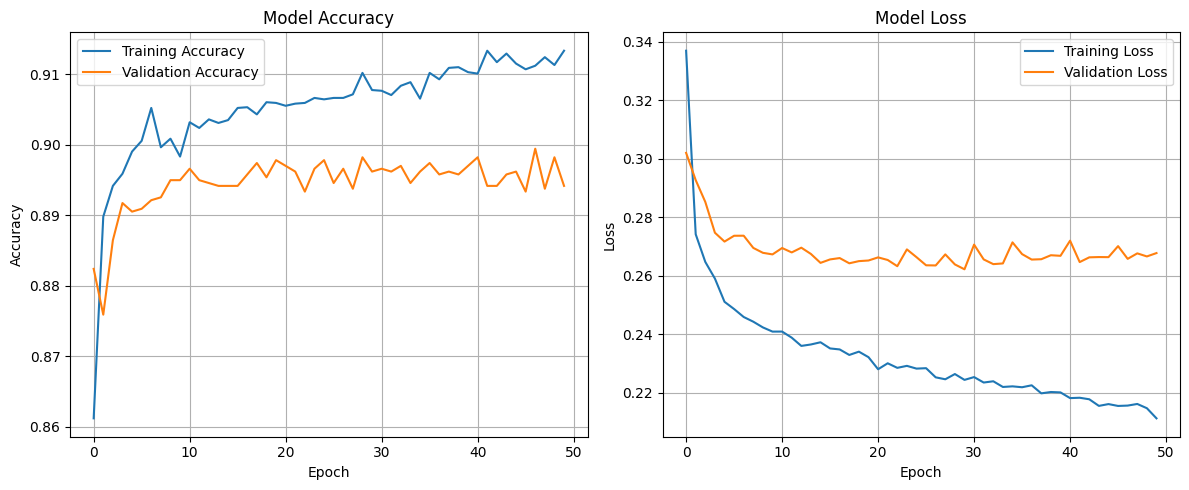

In [45]:
import matplotlib.pyplot as plt

# Asumsikan hasil dari model.fit() disimpan dalam variabel 'history'
# Jika variabel kamu bernama lain (misal: 'hist'), ganti 'history' di bawah ini
# Contoh: history = model.fit(...)

plt.figure(figsize=(12, 5))

# Plot Akurasi
plt.subplot(1, 2, 1) # 1 baris, 2 kolom, plot ke-1
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2) # 1 baris, 2 kolom, plot ke-2
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout() # Merapikan layout
plt.show()

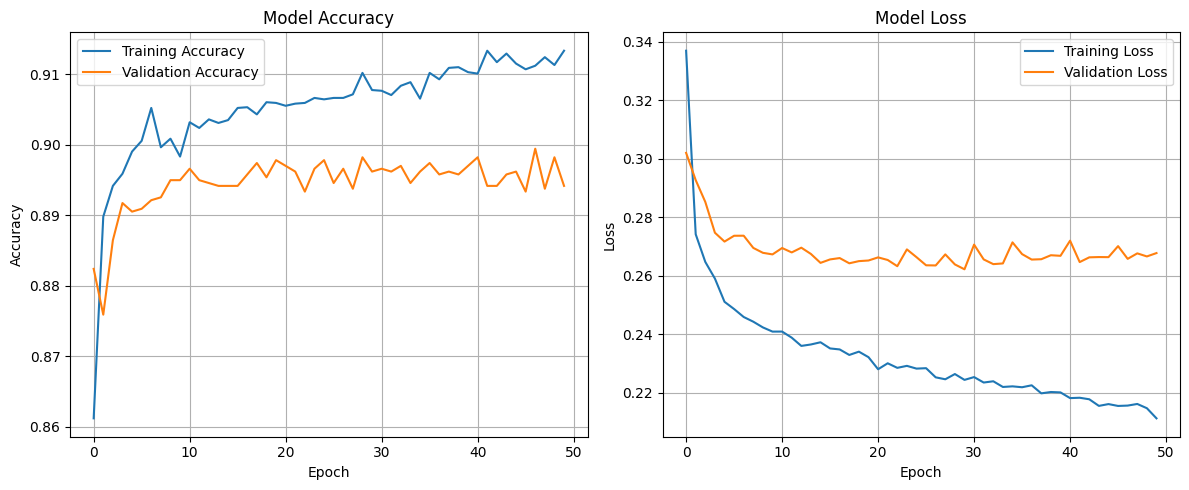

In [47]:
import matplotlib.pyplot as plt

# Asumsikan hasil dari model.fit() disimpan dalam variabel 'history'
# Jika variabel kamu bernama lain (misal: 'hist'), ganti 'history' di bawah ini
# Contoh: history = model.fit(...)

plt.figure(figsize=(12, 5))

# Plot Akurasi
plt.subplot(1, 2, 1) # 1 baris, 2 kolom, plot ke-1
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2) # 1 baris, 2 kolom, plot ke-2
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout() # Merapikan layout
plt.show()

In [43]:
print("Memulai pelatihan model ANN...")
start_time_ann = time.time()
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)
end_time_ann = time.time()
print(f"Pelatihan model ANN selesai. (Durasi: {end_time_ann - start_time_ann:.2f} detik)\n")


Memulai pelatihan model ANN...
Epoch 1/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8174 - loss: 0.4189 - val_accuracy: 0.8824 - val_loss: 0.3020
Epoch 2/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8916 - loss: 0.2688 - val_accuracy: 0.8759 - val_loss: 0.2927
Epoch 3/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8941 - loss: 0.2694 - val_accuracy: 0.8865 - val_loss: 0.2852
Epoch 4/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8965 - loss: 0.2542 - val_accuracy: 0.8917 - val_loss: 0.2747
Epoch 5/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8986 - loss: 0.2551 - val_accuracy: 0.8905 - val_loss: 0.2717
Epoch 6/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9026 - loss: 0.2463 - val_accuracy: 0.8909 - val_loss: 0.2737
Epoch 7/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9023 - loss: 0.2470 - val_accuracy: 0.8921 - val_loss: 0.2737
Epoch 8/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8982 

In [44]:
print("--- Hasil Evaluasi Model ANN ---")
y_pred_ann_prob = model.predict(X_test)
y_pred_ann = (y_pred_ann_prob > 0.5).astype(int)

accuracy_ann = accuracy_score(y_test, y_pred_ann)
print(f"Akurasi pada Data Uji (ANN): {accuracy_ann:.4f}")
print("\nLaporan Klasifikasi Model ANN:")
print(classification_report(y_test, y_pred_ann, target_names=['Tidak Beli (0)', 'Beli (1)']))
print("\nConfusion Matrix Model ANN:")
print(confusion_matrix(y_test, y_pred_ann))
print("-" * 60 + "\n")

--- Hasil Evaluasi Model ANN ---
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Akurasi pada Data Uji (ANN): 0.8942

Laporan Klasifikasi Model ANN:
                precision    recall  f1-score   support

Tidak Beli (0)       0.92      0.96      0.94      2084
      Beli (1)       0.71      0.53      0.61       382

      accuracy                           0.89      2466
     macro avg       0.82      0.74      0.77      2466
  weighted avg       0.89      0.89      0.89      2466


Confusion Matrix Model ANN:
[[2003   81]
 [ 180  202]]
------------------------------------------------------------



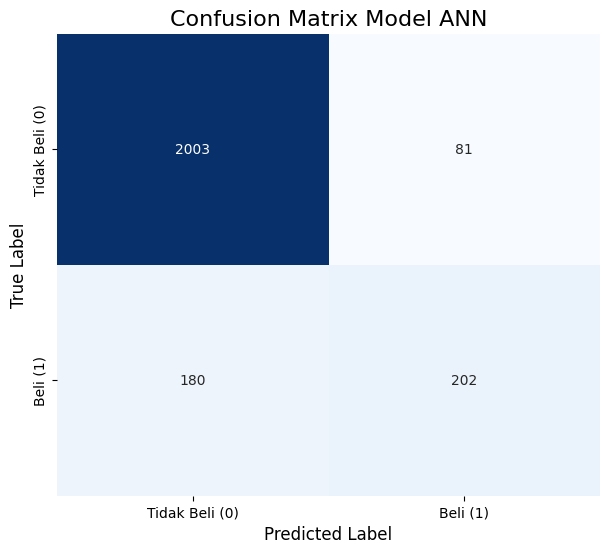

In [48]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Gunakan y_pred_ann yang sudah didefinisikan sebelumnya
cm = confusion_matrix(y_test, y_pred_ann)

plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Tidak Beli (0)', 'Beli (1)'],
            yticklabels=['Tidak Beli (0)', 'Beli (1)'])
plt.title('Confusion Matrix Model ANN', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()